In [1]:
import pandas as pd
import numpy as np

In [3]:
"""
This module is designed to compute various  metrics and populate a DataFrame that replicates (Table 1). 
It includes functions for calculating the number of observations, commodity excess returns, performance metrics, 
first-to-expire contracts, basis time series, mean basis, frequency of backwardation, 
and combining these metrics into a final table. 
"""

import warnings

warnings.filterwarnings("ignore")

from pathlib import Path
import pandas as pd
import numpy as np
import logging

logging.basicConfig(level=logging.INFO, format="%(message)s")


def compute_num_observations(prep_df):
    """
    Calculates the number of observations per commodity.

    Parameters:
        prep_df (DataFrame): Preprocessed DataFrame containing commodity data.

    Returns:
        Series: A Series containing the average number of observations per month for each commodity.
    """

    df = prep_df
    df.reset_index(inplace=True)
    total_cmdty_obs = df.groupby(["Commodity"])["Date"].count()
    total_cmdty_mths = df.groupby(["Commodity"])["YearMonth"].nunique()
    obs_df = pd.merge(
        total_cmdty_obs,
        total_cmdty_mths,
        how="left",
        left_on="Commodity",
        right_on="Commodity",
    )
    obs_df.rename(
        columns={"Date": "Total_Observations", "YearMonth": "NumMths"}, inplace=True
    )
    obs_df["N"] = obs_df["Total_Observations"] / obs_df["NumMths"]
    return obs_df["N"]


def compute_commodity_excess_returns(prep_df):
    """
    Computes monthly excess returns for the second contract of each commodity.

    Parameters:
        prep_df (DataFrame): Preprocessed DataFrame containing commodity data.

    Returns:
        DataFrame: A DataFrame containing monthly excess returns for the second contract of each commodity.
    """

    cmdty_cntrct_2_df = prep_df[prep_df["Contract"] == 2]
    cmdty_cntrct_2_df.reset_index(inplace=True)
    max_date_px_last_cntrct_2 = (
        cmdty_cntrct_2_df.groupby(["Commodity", "YearMonth"])
        .apply(lambda x: x.loc[x["Date"].idxmax(), ["Date", "ClosePrice"]])
        .reset_index()
    )
    max_date_px_last_cntrct_2.sort_values(by=["Commodity", "YearMonth"], inplace=True)
    max_date_px_last_cntrct_2.set_index("Date", inplace=True)
    max_date_px_last_cntrct_2_pivot = max_date_px_last_cntrct_2.pivot_table(
        index="Date", columns="Commodity", values="ClosePrice"
    )
    cmdty_cntrct_2_rets_df = max_date_px_last_cntrct_2_pivot.pct_change()
    return cmdty_cntrct_2_rets_df


def compute_performance_metrics(excess_returns_df, annualizing_period=12):
    """
    Computes annualized performance metrics for commodities based on excess returns.

    Parameters:
        excess_returns_df (DataFrame): DataFrame containing monthly excess returns for commodities.
        annualizing_factor (int): Factor used to annualize the metrics, default is 12 (for monthly data).

    Returns:
        DataFrame: A DataFrame containing annualized mean, volatility, and Sharpe ratio for each commodity.
    """

    avg_hist_excess_returns = excess_returns_df.mean() * annualizing_period * 100
    std_hist_excess_returns = (
        excess_returns_df.std() * np.sqrt(annualizing_period) * 100
    )
    sharpe_ratio = avg_hist_excess_returns / std_hist_excess_returns
    performance_metrics = pd.DataFrame(
        {
            "Ann. Excess Returns": avg_hist_excess_returns,
            "Ann. Volatility": std_hist_excess_returns,
            "Ann. Sharpe Ratio": sharpe_ratio,
        }
    )
    return performance_metrics


def get_first_last_to_expire_contract(
    prep_df, first_to_exp_ind=1, last_to_expire=False
):
    """
    Retrieves close prices for the first and last to expire contracts for each commodity.

    Parameters:
        prep_df (DataFrame): Preprocessed DataFrame containing commodity data.
        first_to_expire_index (int): Index of the contract considered as 'first to expire'.
        last_to_expire (bool): Flag indicating whether to return last to expire contracts.

    Returns:
        DataFrame: A DataFrame containing close prices for the specified contracts.
    """

    cmdty_df = prep_df

    # Get Commodities which have more than 1 contracts against the same date
    cmdtry_cntrct_count = (
        cmdty_df.groupby(["Commodity", "Date"])["Contract"]
        .nunique()
        .reset_index(name="Distinct_Contracts")
    )
    cmdtry_cntrct_atlst_2 = cmdtry_cntrct_count[
        cmdtry_cntrct_count["Distinct_Contracts"] >= 2
    ]

    # Get list of the commodities for the aforementioned criterion
    list_of_commodities = cmdtry_cntrct_atlst_2["Commodity"].unique()

    # Filter the data to only get the subset of interest
    cmdty_entire_df = cmdty_df[cmdty_df["Commodity"].isin(list_of_commodities)]
    cmdty_entire_df.reset_index(inplace=True)

    # Getting Close Prices for 1st to Expire Contract Per Commodity
    cmdty_cntrct_first_to_expire_df = cmdty_entire_df[
        cmdty_entire_df["Contract"] == first_to_exp_ind
    ]
    max_date_price_first_exp = (
        cmdty_cntrct_first_to_expire_df.groupby(["Commodity", "YearMonth"])
        .apply(lambda x: x.loc[x["Date"].idxmax(), ["Date", "Contract", "ClosePrice"]])
        .reset_index()
    )
    max_date_price_first_exp["uid"] = (
        max_date_price_first_exp["Commodity"]
        + max_date_price_first_exp["Date"].astype(str)
        + max_date_price_first_exp["Contract"].astype(str)
    )
    max_date_price_first_exp.sort_values(by=["Commodity", "YearMonth"], inplace=True)

    #### Last to Expire ####
    # Getting Close Prices for Last to Expire Contract per Commodity
    cmdty_cntrct_last_to_expire_df = cmdty_entire_df[
        cmdty_entire_df["Contract"] > first_to_exp_ind
    ]
    max_date_cntrct_last_exp_df = (
        cmdty_cntrct_last_to_expire_df.groupby(["Commodity", "YearMonth"])
        .agg(Max_Date=("Date", "max"), Max_Contract_Number=("Contract", "max"))
        .reset_index()
    )

    cmdty_entire_df_temp = cmdty_entire_df
    cmdty_entire_df_temp["uid"] = (
        cmdty_entire_df_temp["Commodity"]
        + cmdty_entire_df_temp["Date"].astype(str)
        + cmdty_entire_df_temp["Contract"].astype(str)
    )
    max_date_cntrct_last_exp_df["uid"] = (
        max_date_cntrct_last_exp_df["Commodity"]
        + max_date_cntrct_last_exp_df["Max_Date"].astype(str)
        + max_date_cntrct_last_exp_df["Max_Contract_Number"].astype(str)
    )
    max_date_cntrct_last_exp_price_df = pd.merge(
        max_date_cntrct_last_exp_df,
        cmdty_entire_df_temp[["uid", "ClosePrice"]],
        how="left",
        left_on="uid",
        right_on="uid",
    )

    max_date_price_first_exp.drop(columns=["uid"], inplace=True)
    max_date_price_first_exp.reset_index()

    max_date_cntrct_last_exp_price_df.drop(columns=["uid"], inplace=True)
    max_date_cntrct_last_exp_price_df.reset_index()

    if last_to_expire == False:
        return max_date_price_first_exp
    else:
        return max_date_cntrct_last_exp_price_df


def compute_basis_timeseries(prep_df):
    """
    Computes the basis time series for commodities.

    Parameters:
        prep_df (DataFrame): Preprocessed DataFrame containing commodity data.

    Returns:
        DataFrame: A DataFrame containing the basis time series for each commodity.
    """

    prep_df = prep_df
    first_to_expire = get_first_last_to_expire_contract(prep_df, 1, False)
    first_to_expire["uid"] = first_to_expire["Commodity"] + first_to_expire[
        "Date"
    ].astype(str)

    last_to_expire = get_first_last_to_expire_contract(prep_df, 1, True)
    last_to_expire["uid"] = last_to_expire["Commodity"] + last_to_expire[
        "Max_Date"
    ].astype(str)

    basis_df_base = pd.merge(
        first_to_expire,
        last_to_expire[["uid", "Max_Contract_Number", "ClosePrice"]],
        how="left",
        left_on="uid",
        right_on="uid",
    )
    basis_df_base.rename(
        columns={
            "ClosePrice_x": "ClosePriceFstExp",
            "ClosePrice_y": "ClosePriceLstExp",
        },
        inplace=True,
    )
    basis_df_base["LogClosePriceFstExp"] = np.log(basis_df_base["ClosePriceFstExp"])
    basis_df_base["LogClosePriceLstExp"] = np.log(basis_df_base["ClosePriceLstExp"])
    basis_df_base["LogPriceDiff"] = (
        basis_df_base["LogClosePriceFstExp"] - basis_df_base["LogClosePriceLstExp"]
    )
    basis_df_base["ExpDiff"] = (
        basis_df_base["Max_Contract_Number"] - basis_df_base["Contract"]
    )
    basis_df_base["Basis"] = basis_df_base["LogPriceDiff"] / basis_df_base["ExpDiff"]
    basis_df_base.set_index("Date", inplace=True)

    return basis_df_base


def compute_basis_mean(prep_df):
    """
    Computes the mean basis for each commodity.

    Parameters:
        prep_df (DataFrame): Preprocessed DataFrame containing commodity data.

    Returns:
        Series: A Series containing the mean basis for each commodity.
    """

    prep_df = prep_df
    timeseries_basis = compute_basis_timeseries(prep_df)
    mean_basis = timeseries_basis.groupby(["Commodity"])["Basis"].mean()
    return mean_basis


def compute_freq_backwardation(prep_df):
    """
    Computes the frequency of backwardation for each commodity.

    Parameters:
        prep_df (DataFrame): Preprocessed DataFrame containing commodity data.

    Returns:
        DataFrame: A DataFrame containing the frequency of backwardation for each commodity.
    """

    prep_df = prep_df
    timeseries_basis = compute_basis_timeseries(prep_df)
    timeseries_basis["in_backwardation"] = timeseries_basis["Basis"].apply(
        lambda x: 1 if x > 0 else 0
    )

    total_basis_count = (
        timeseries_basis.groupby("Commodity")["in_backwardation"].size().to_frame()
    )
    total_basis_count.reset_index(inplace=True)
    total_basis_count.rename(
        columns={"in_backwardation": "TotalBasisCount"}, inplace=True
    )

    poistive_basis = (
        timeseries_basis.groupby("Commodity")["in_backwardation"].sum().reset_index()
    )
    poistive_basis.rename(
        columns={"in_backwardation": "PositiveBasisCount"}, inplace=True
    )

    backwardation_calc_df = pd.merge(
        total_basis_count,
        poistive_basis,
        how="left",
        left_on="Commodity",
        right_on="Commodity",
    )
    backwardation_calc_df["Freq. of Backwardation"] = (
        backwardation_calc_df["PositiveBasisCount"]
        / backwardation_calc_df["TotalBasisCount"]
    ) * 100
    backwardation_calc_df.set_index("Commodity", inplace=True)

    return backwardation_calc_df


def combine_metrics(prep_df):
    """
    Combines computed metrics into a single DataFrame.

    Parameters:
        prep_df (DataFrame): Preprocessed DataFrame containing commodity data.

    Returns:
        DataFrame: A DataFrame containing combined metrics for each commodity.
    """

    prep_df = prep_df
    N = compute_num_observations(prep_df)
    returns_df = compute_commodity_excess_returns(prep_df)
    performance_metrics = compute_performance_metrics(returns_df)
    avg_basis = compute_basis_mean(prep_df)
    back_freq = compute_freq_backwardation(prep_df)
    metrics_df = pd.concat([N, performance_metrics, avg_basis, back_freq], axis=1)
    metrics_df.drop(columns=["TotalBasisCount", "PositiveBasisCount"], inplace=True)
    metrics_df.reset_index(inplace=True)

    commodity_sector_mapping = {
        "Cocoa": "Agriculture",
        "Corn": "Agriculture",
        "Cotton": "Agriculture",
        "Live cattle": "Livestock",
        "Oats": "Agriculture",
        "Orange juice": "Agriculture",
        "Soybean meal": "Agriculture",
        "Soybeans": "Agriculture",
        "Wheat": "Agriculture",
        "Feeder cattle": "Livestock",
        "Coffee": "Agriculture",
        "Gold": "Metals",
        "Silver": "Metals",
        "Canola": "Agriculture",
        "Crude Oil": "Energy",
        "Heating Oil": "Energy",
        "Lean hogs": "Livestock",
        "Palladium": "Metals",
        "Platinum": "Metals",
        "Lumber": "Agriculture",
        "Unleaded gas": "Energy",
        "Copper": "Metals",
        "Rough rice": "Agriculture",
        "Natural gas": "Energy",
        "Aluminium": "Metals",
        "Gasoline": "Energy",
    }
    commodity_symbol_mapping = {
        "Canola": "WC",
        "Cocoa": "CC",
        "Coffee": "KC",
        "Corn": "C-",
        "Cotton": "CT",
        "Lumber": "LB",
        "Oats": "O-",
        "Orange juice": "JO",
        "Rough rice": "RR",
        "Soybean meal": "SM",
        "Soybeans": "S-",
        "Wheat": "W-",
        "Crude Oil": "CL",
        "Gasoline": "RB",
        "Heating Oil": "HO",
        "Natural gas": "NG",
        "Unleaded gas": "HU",
        "Feeder cattle": "FC",
        "Lean hogs": "LH",
        "Live cattle": "LC",
        "Aluminium": "AL",
        "Copper": "HG",
        "Gold": "GC",
        "Palladium": "PA",
        "Platinum": "PL",
        "Silver": "SI",
    }

    metrics_df["Sector"] = metrics_df["Commodity"].map(commodity_sector_mapping)
    metrics_df["Symbol"] = metrics_df["Commodity"].map(commodity_symbol_mapping)
    metrics_df_final = metrics_df[
        [
            "Sector",
            "Commodity",
            "Symbol",
            "N",
            "Basis",
            "Freq. of Backwardation",
            "Ann. Excess Returns",
            "Ann. Volatility",
            "Ann. Sharpe Ratio",
        ]
    ]
    metrics_df_final.set_index(["Sector", "Commodity"], inplace=True)
    metrics_df_final.sort_index(inplace=True)

    metrics_df_final = metrics_df_final.rename(
        columns={
            "Freq. of Backwardation": "Freq. of bw.",
            "Ann. Excess Returns": "Excess returns",
            "Ann. Volatility": "Volatility",
            "Ann. Sharpe Ratio": "Sharpe ratio",
        }
    )
    metrics_df_final["N"] = metrics_df_final["N"].astype(int)

    metrics_df_final = metrics_df_final.style.format(
        {
            "Basis": "{:.2f}",
            "Freq. of bw.": "{:.2f}",
            "Excess returns": "{:.2f}",
            "Volatility": "{:.2f}",
            "Sharpe ratio": "{:.2f}",
        }
    )

    return metrics_df_final

In [4]:
clean_data_file_path = "clean_1970_2008_commodities_data.csv"
clean_data_file_new = "clean_2009_2024_commodities_data.csv"
clean_data_df_1970 = pd.read_csv(clean_data_file_path)
clean_data_df_2009 = pd.read_csv(clean_data_file_new)


combined_metrics_df_1970 = combine_metrics(clean_data_df_1970)

combined_metrics_df_2009 = combine_metrics(clean_data_df_2009)

In [5]:
combined_metrics_df_1970

In [6]:
combined_metrics_df_2009

In [21]:
clean_data_df_1970.head(5)

,index,Date,Commodity,Contract,ClosePrice,YearMonth
0,0,1970-01-05,Cocoa,1,865.0,1970-01
1,1,1970-01-05,Cocoa,2,3391.0,1970-01
2,2,1970-01-05,Cocoa,3,3293.0,1970-01
3,3,1970-01-05,Cocoa,4,3029.0,1970-01
4,4,1970-01-05,Cocoa,5,2912.0,1970-01


In [9]:
df = pd.concat([clean_data_df_1970, clean_data_df_1970], ignore_index=True)

In [17]:
df = df[df["Contract"] <= 4]
df["Date"] = pd.to_datetime(df["Date"])
df["YearMonth"] = df["Date"].dt.to_period("M")

In [22]:
last_prices = (
    df.groupby(["Commodity", "YearMonth", "Contract"])
    .apply(lambda x: x.loc[x["Date"].idxmax()])
    .reset_index(drop=True)
)

In [26]:
avg_price = (
    last_prices.groupby(["Commodity", "YearMonth"])["ClosePrice"].mean().reset_index()
)
avg_price_pivot = avg_price.pivot(
    index="YearMonth", columns="Commodity", values="ClosePrice"
)
monthly_return = avg_price_pivot.pct_change()

In [27]:
monthly_return

Commodity,Aluminium,Canola,Cocoa,Coffee,Copper,Corn,Cotton,Crude Oil,Feeder cattle,Gasoline,...,Oats,Orange juice,Palladium,Platinum,Rough rice,Silver,Soybean meal,Soybeans,Unleaded gas,Wheat
YearMonth,,,,,,,,,,,,,,,,,,,,,
1970-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-02,NaN,NaN,-0.123671,NaN,NaN,0.007088,0.000185,NaN,NaN,NaN,...,-0.029467,-0.216957,NaN,NaN,NaN,NaN,0.023906,0.011436,NaN,0.050846
1970-03,NaN,NaN,-0.011430,NaN,NaN,-0.002096,-0.005357,NaN,NaN,NaN,...,0.003023,-0.003294,NaN,NaN,NaN,NaN,-0.030540,-0.002043,NaN,-0.018365
1970-04,NaN,NaN,-0.029023,NaN,NaN,0.046477,-0.032689,NaN,NaN,NaN,...,0.007841,0.065287,NaN,NaN,NaN,NaN,0.035480,0.020748,NaN,0.045064
1970-05,NaN,NaN,-0.047874,NaN,NaN,-0.003700,0.014977,NaN,NaN,NaN,...,0.122532,-0.086602,NaN,NaN,NaN,NaN,-0.015990,0.000000,NaN,-0.052928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-08,-0.093862,-0.098416,0.000618,0.017975,-0.066041,-0.036294,-0.063181,-0.073281,-0.046616,-0.052962,...,-0.086806,0.014803,-0.222094,-0.190803,0.126739,-0.235741,-0.042307,-0.055107,0.0,-0.007703
2008-09,-0.112180,-0.208172,-0.103527,-0.096114,-0.143256,-0.159774,-0.173355,-0.104773,-0.058181,-0.130772,...,-0.121552,-0.193597,-0.260143,-0.305435,-0.002659,-0.104970,-0.203400,-0.205218,0.0,-0.148335
2008-10,-0.166181,-0.045133,-0.191127,-0.125232,-0.362014,-0.170637,-0.215814,-0.324182,-0.052974,-0.381722,...,-0.246748,-0.128675,-0.011804,-0.167778,-0.203077,-0.213441,-0.048561,-0.120950,0.0,-0.205628


In [32]:
pivot_table = df.pivot_table(
    values="ClosePrice", index=["YearMonth"], columns="Commodity", aggfunc="mean"
)

In [34]:
monthly_return2 = pivot_table.pct_change()

In [ ]:
monthly_return["Month"] = pd.to_datetime(
    monthly_return.index.astype(str), format="%Y-%m"
)
monthly_return2["Month"] = pd.to_datetime(
    monthly_return.index.astype(str), format="%Y-%m"
)
monthly_return = monthly_return.set_index("Month")
monthly_return2 = monthly_return2.set_index("Month")

KeyError: "None of ['Month'] are in the columns"

In [52]:
import sys
from pathlib import Path

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Plotting style
sns.set()

# Add project root to path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

# Load project modules
from he_kelly_manela import pull_he_kelly_manela

# Load project settings
from settings import config

DATA_DIR = Path(config("DATA_DIR")) / "cds_returns"
HE_DATA_DIR = Path(config("DATA_DIR")) / "he_kelly_manela"

from he_kelly_manela import pull_he_kelly_manela

he_kelly = pull_he_kelly_manela.load_he_kelly_manela_all(data_dir=HE_DATA_DIR)

he_kelly.columns.str.contains("cmd").sum()


col_lst = ["yyyymm"]
for i in range(1, 10):
    col_lst.append(f"Commod_0{i}")
for i in range(10, 24):
    col_lst.append(f"Commod_{i}")

# %%
he_kelly_df = he_kelly[col_lst].dropna(axis=0)
he_kelly_df["Month"] = pd.to_datetime(
    he_kelly_df["yyyymm"].astype(int).astype(str), format="%Y%m"
)
he_kelly_df = he_kelly_df.drop(columns="yyyymm")
he_kelly_df = he_kelly_df.set_index("Month")

In [85]:
common_idx = he_kelly_df.index.intersection(monthly_return.index)

he_kelly_sub = he_kelly_df.loc[common_idx]
carry_sub = monthly_return.loc[common_idx]

corr_matrix = pd.DataFrame(index=carry_sub.columns, columns=he_kelly_df.columns)


for col1 in carry_sub.columns:
    for col2 in he_kelly_df.columns:
        x = carry_sub[col1].fillna(0)
        y = he_kelly_df[col2].fillna(0)
        corr_matrix.loc[col1, col2] = x.corr(y)

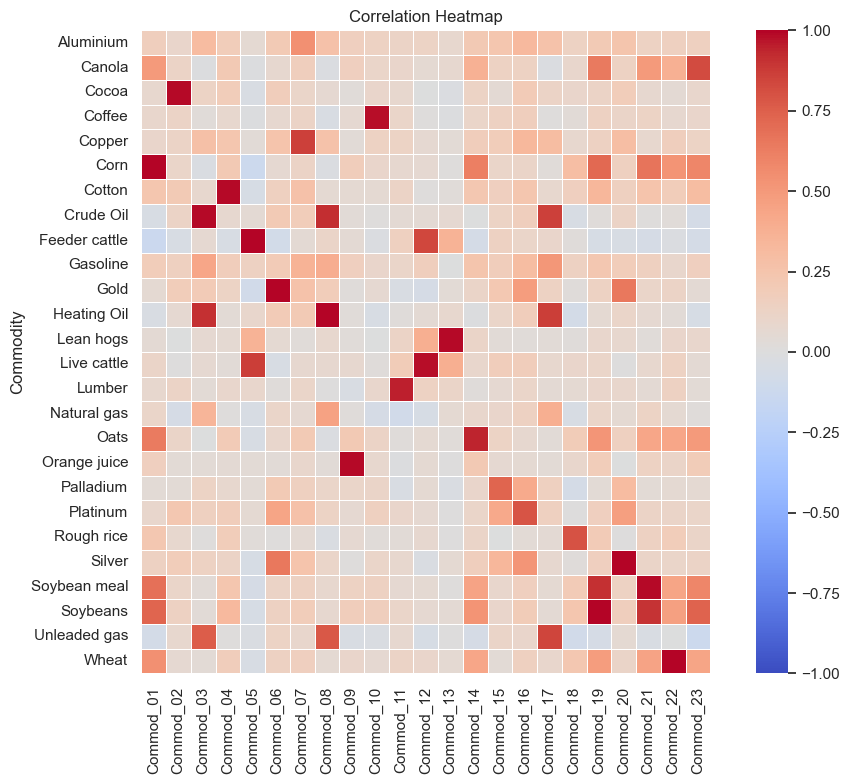

In [86]:
corr_matrix_float = corr_matrix.astype(float)
import matplotlib.pyplot as plt
import seaborn as sns


corr_matrix = corr_matrix.astype(float)

plt.figure(figsize=(10, 8))

sns.heatmap(
    corr_matrix_float,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar=True,
)

plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [76]:
monthly_return2.index = monthly_return2.index.to_timestamp(how="start")

In [77]:
common_idx = he_kelly_df.index.intersection(monthly_return2.index)

he_kelly_sub = he_kelly_df.loc[common_idx]
carry_sub = monthly_return2.loc[common_idx]

corr_matrix = pd.DataFrame(index=carry_sub.columns, columns=he_kelly_df.columns)


for col1 in carry_sub.columns:
    for col2 in he_kelly_df.columns:
        x = carry_sub[col1].fillna(0)
        y = he_kelly_df[col2].fillna(0)
        corr_matrix.loc[col1, col2] = x.corr(y)

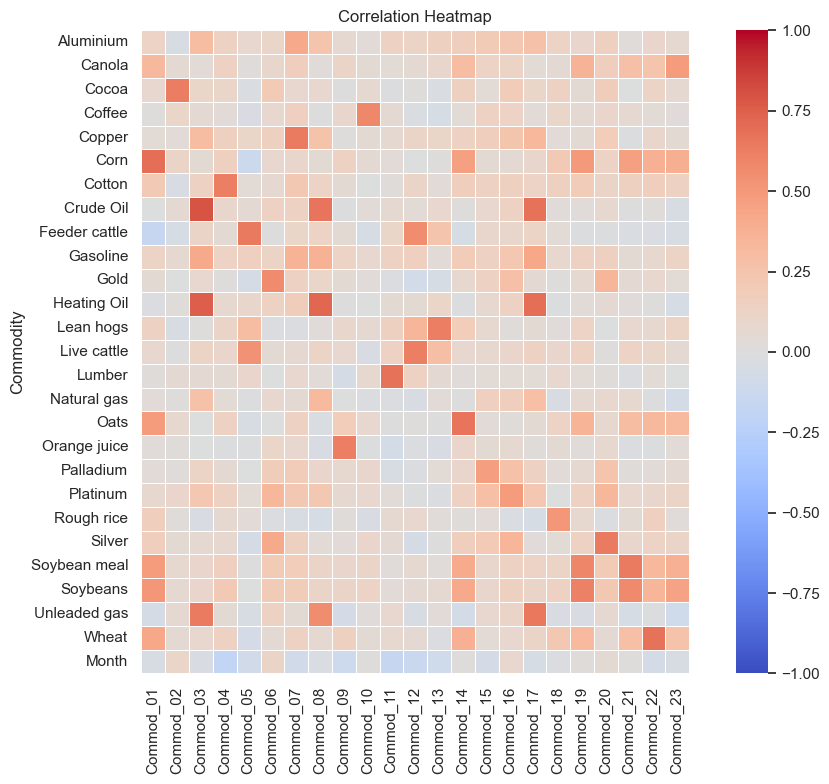

In [78]:
corr_matrix_float = corr_matrix.astype(float)
import matplotlib.pyplot as plt
import seaborn as sns


corr_matrix = corr_matrix.astype(float)

plt.figure(figsize=(10, 8))

sns.heatmap(
    corr_matrix_float,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar=True,
)

plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [79]:
corr_matrix

,Commod_01,Commod_02,Commod_03,Commod_04,Commod_05,Commod_06,Commod_07,Commod_08,Commod_09,Commod_10,...,Commod_14,Commod_15,Commod_16,Commod_17,Commod_18,Commod_19,Commod_20,Commod_21,Commod_22,Commod_23
Commodity,,,,,,,,,,,,,,,,,,,,,
Aluminium,0.132389,-0.041136,0.304593,0.137705,0.082052,0.105963,0.415218,0.256382,0.067468,0.038555,...,0.164489,0.196602,0.231548,0.273062,0.128123,0.094147,0.149999,0.025153,0.099096,0.065169
Canola,0.327566,0.062449,0.036744,0.147427,0.022468,0.090424,0.165237,0.024925,0.109641,0.053529,...,0.299333,0.130940,0.118865,0.046667,0.058515,0.359399,0.164931,0.273944,0.256087,0.487386
Cocoa,0.079769,0.629277,0.108374,0.106372,-0.024557,0.199241,0.078618,0.084606,0.001328,0.066829,...,0.154049,0.043660,0.190609,0.107058,0.146590,0.053728,0.177514,-0.002094,0.119486,0.063986
Coffee,0.015119,0.107237,0.055925,0.035442,-0.037995,0.080412,0.160819,0.003416,0.087602,0.582558,...,0.045965,0.142854,0.127361,0.032731,0.105297,0.055221,0.097153,0.063774,0.043809,0.026328
Copper,0.045970,0.033435,0.303869,0.151596,0.107720,0.154720,0.635737,0.265052,0.009646,0.052785,...,0.146006,0.171641,0.243569,0.328632,0.037931,0.047764,0.183478,-0.008959,0.087933,0.052167
Corn,0.691666,0.116241,0.048423,0.150915,-0.120738,0.079874,0.088439,0.048141,0.139721,0.056716,...,0.465387,0.050315,0.061554,0.092741,0.215888,0.498536,0.131181,0.465833,0.375563,0.390568
Cotton,0.216743,-0.036857,0.146012,0.623753,0.043474,0.066177,0.223123,0.127042,0.048753,-0.002575,...,0.168931,0.133441,0.150310,0.130576,0.156240,0.188027,0.109646,0.153106,0.166846,0.146727
Crude Oil,-0.006371,0.059043,0.790178,0.087155,0.055297,0.133936,0.147447,0.667898,-0.009630,0.034892,...,0.012504,0.083069,0.140419,0.674937,0.030570,0.026787,0.070825,0.005298,0.017524,-0.043548
Feeder cattle,-0.158650,-0.051216,0.115292,0.047215,0.647955,0.000902,0.107019,0.132173,0.047408,-0.052348,...,-0.048409,0.086142,0.091078,0.122937,0.043743,-0.013786,-0.012721,-0.024301,-0.029346,-0.044405


In [87]:
from scipy.optimize import linear_sum_assignment

cost_matrix = -corr_matrix.values.astype(float)

# Step 2: Solve assignment problem
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Step 3: Extract optimal pairs
optimal_pairs = []

for r, c in zip(row_ind, col_ind):
    row_label = corr_matrix.index[r]
    col_label = corr_matrix.columns[c]
    corr_value = corr_matrix.iloc[r, c]
    optimal_pairs.append((row_label, col_label, corr_value))

# Convert to DataFrame for easy viewing
optimal_pairs_df = pd.DataFrame(
    optimal_pairs, columns=["Commodity_1", "Commodity_2", "Correlation"]
)

# Sort by correlation (optional)
optimal_pairs_df = optimal_pairs_df.sort_values(by="Correlation", ascending=False)
optimal_pairs_df.reset_index(drop=True)

,Commodity_1,Commodity_2,Correlation
0,Gold,Commod_06,0.998063
1,Silver,Commod_20,0.996785
2,Heating Oil,Commod_08,0.995794
3,Feeder cattle,Commod_05,0.995749
4,Soybeans,Commod_19,0.994824
5,Wheat,Commod_22,0.993217
6,Corn,Commod_01,0.992310
7,Cocoa,Commod_02,0.990959
8,Soybean meal,Commod_21,0.990531
9,Lean hogs,Commod_13,0.988593


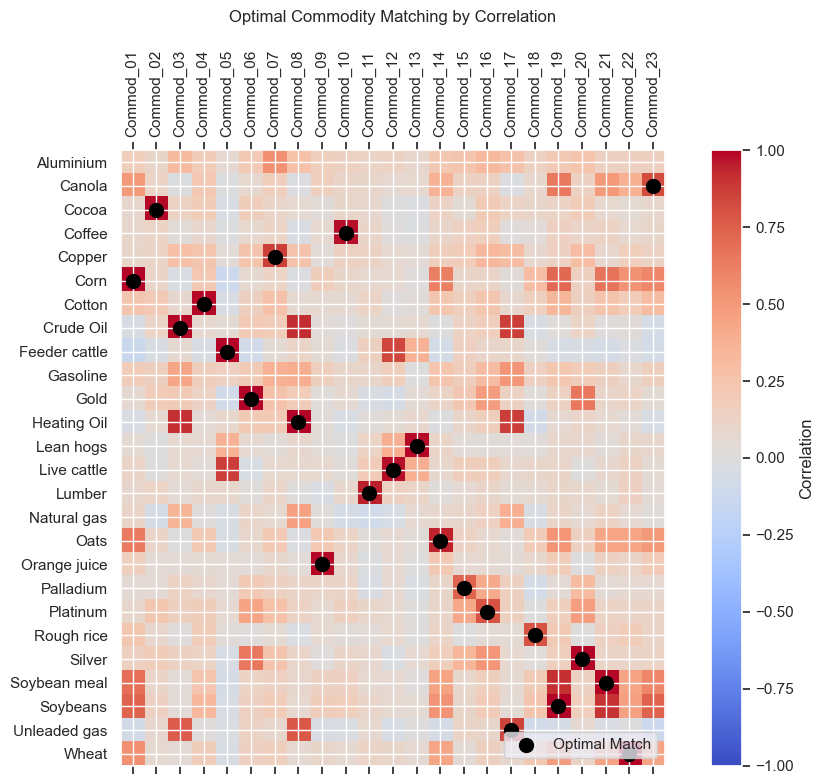

In [88]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the correlation matrix as background heatmap
cax = ax.matshow(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)

# Plot the optimal matches as black dots
ax.scatter(col_ind, row_ind, color="black", marker="o", s=100, label="Optimal Match")

# Axis ticks and labels
ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_yticks(range(len(corr_matrix.index)))

ax.set_xticklabels(corr_matrix.columns, rotation=90)
ax.set_yticklabels(corr_matrix.index)

# Color bar
fig.colorbar(cax, label="Correlation")

# Title and legend
plt.title("Optimal Commodity Matching by Correlation", pad=20)
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

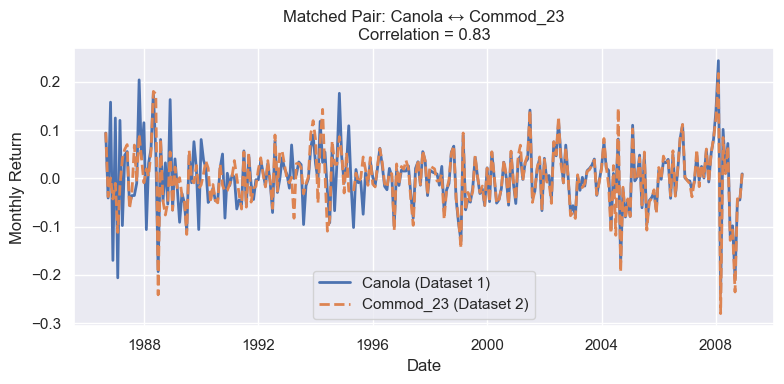

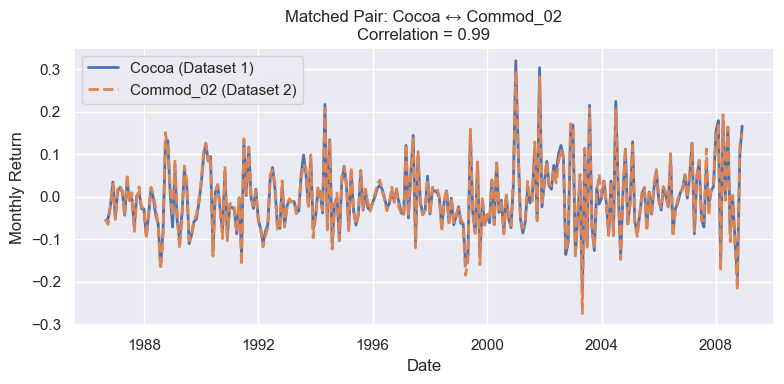

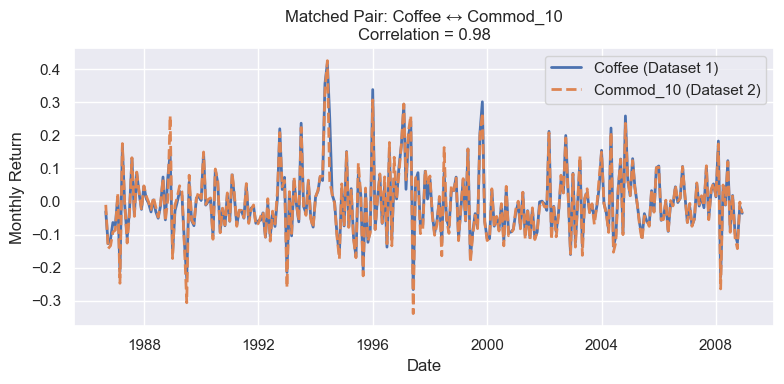

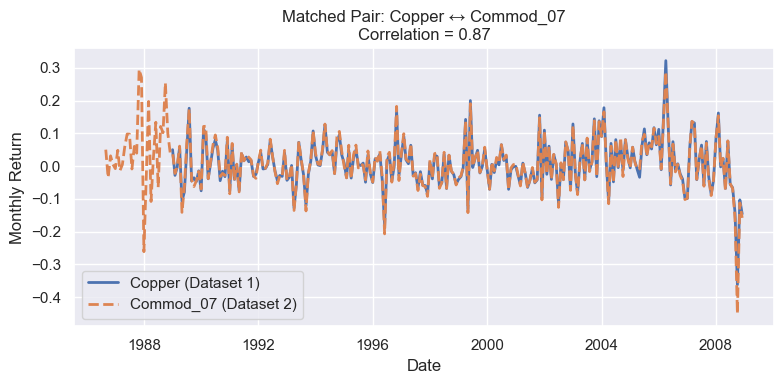

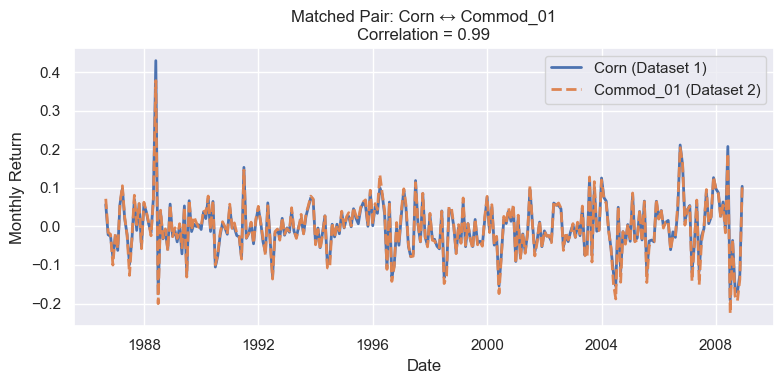

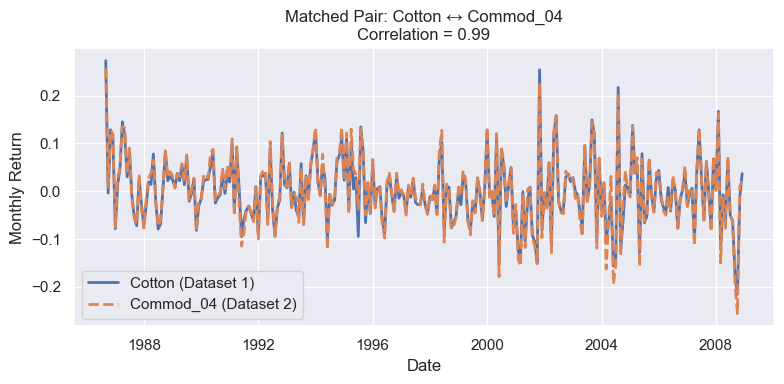

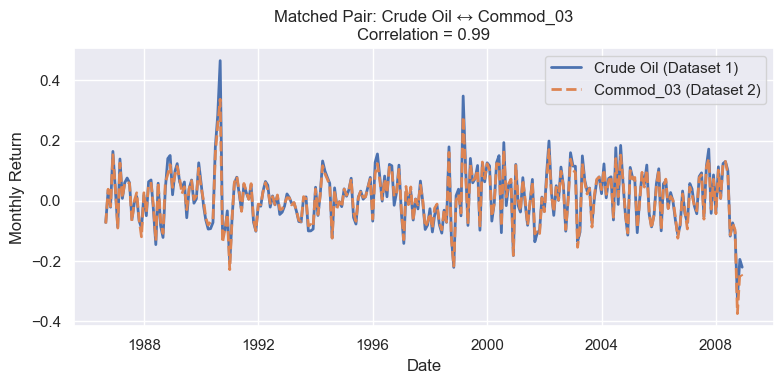

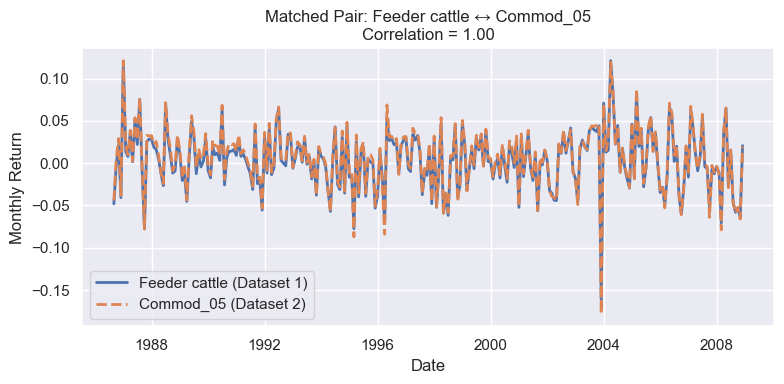

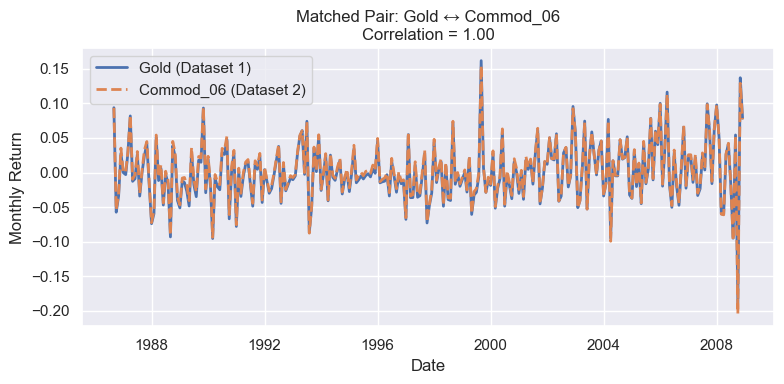

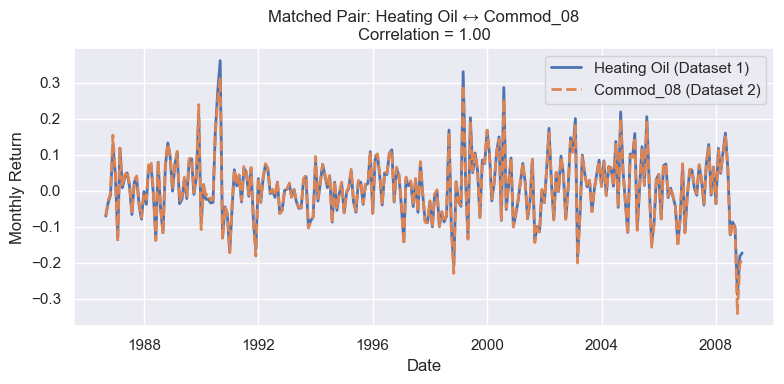

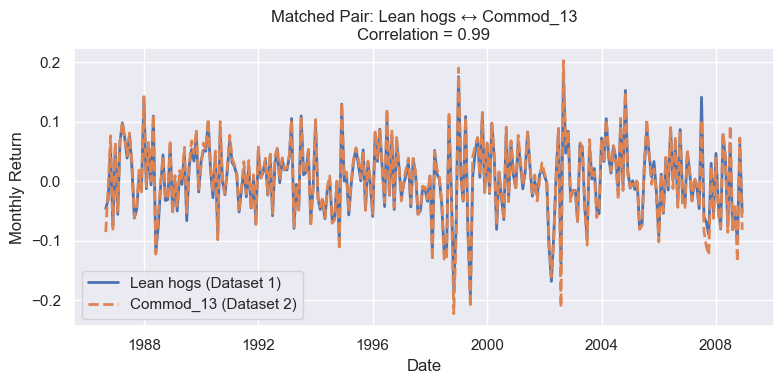

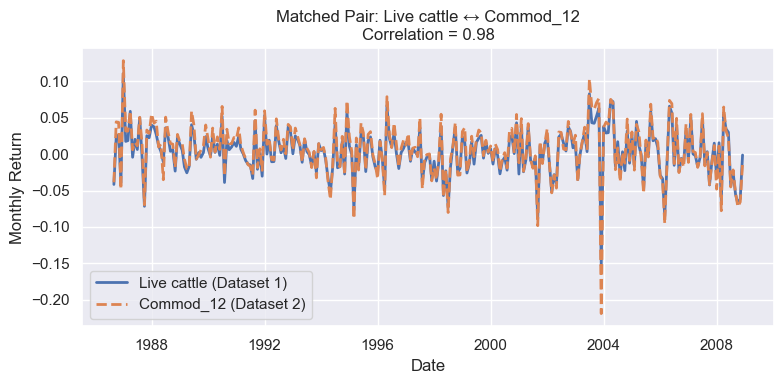

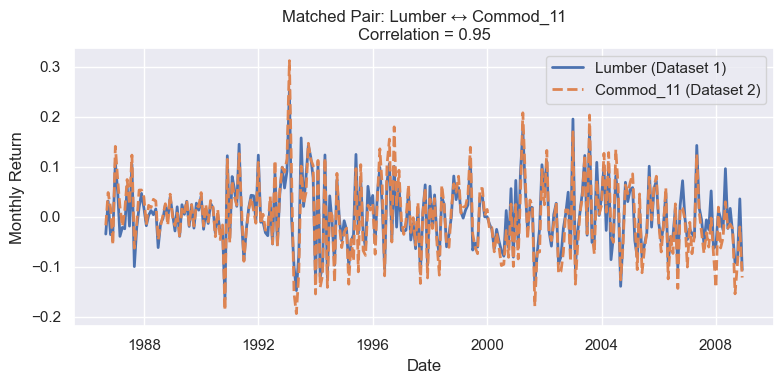

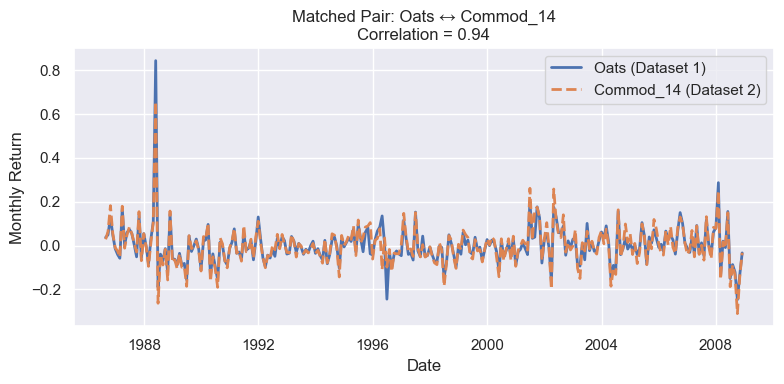

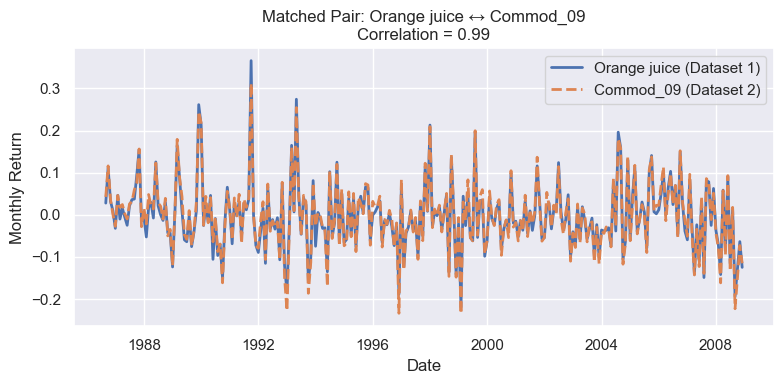

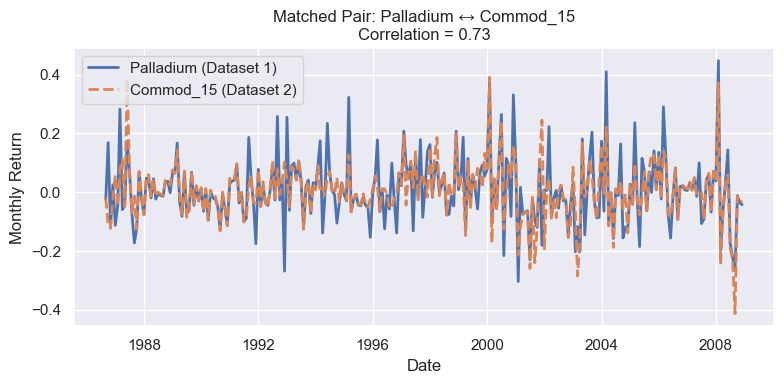

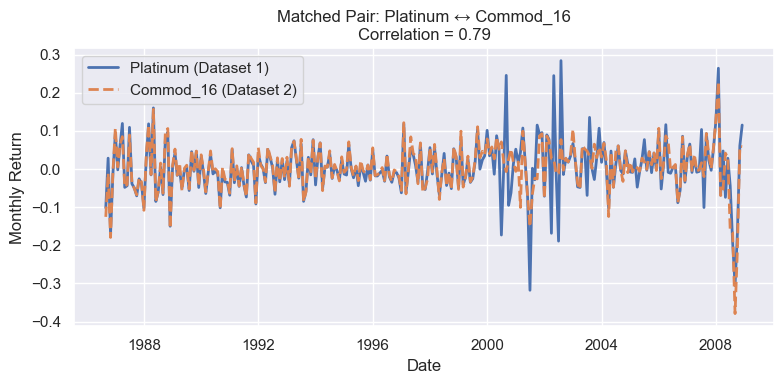

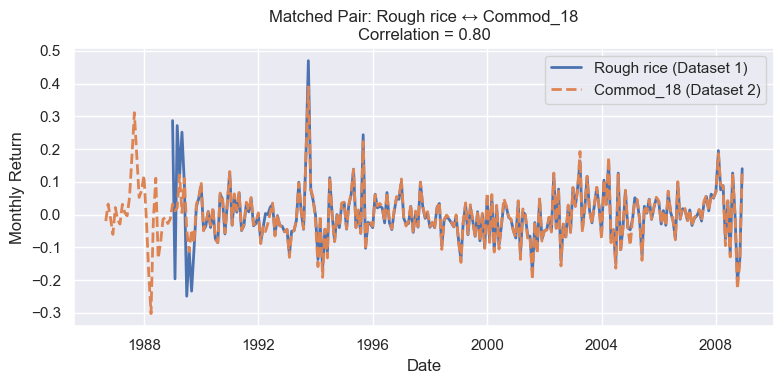

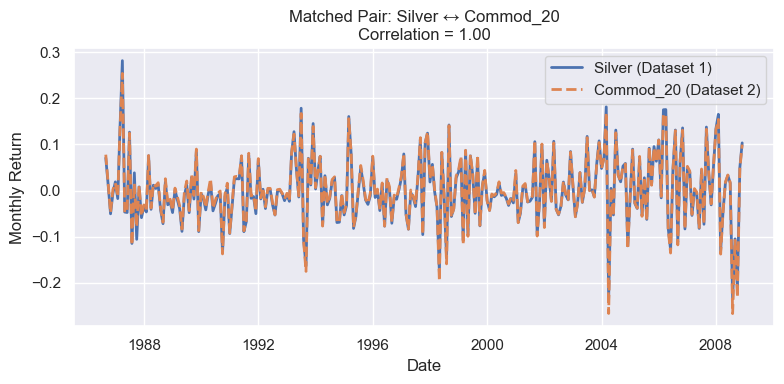

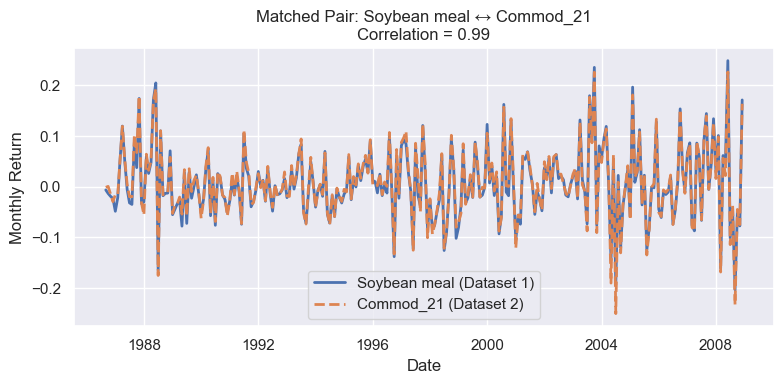

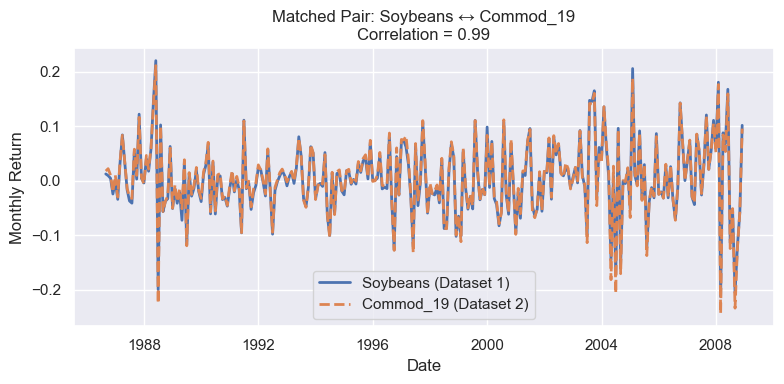

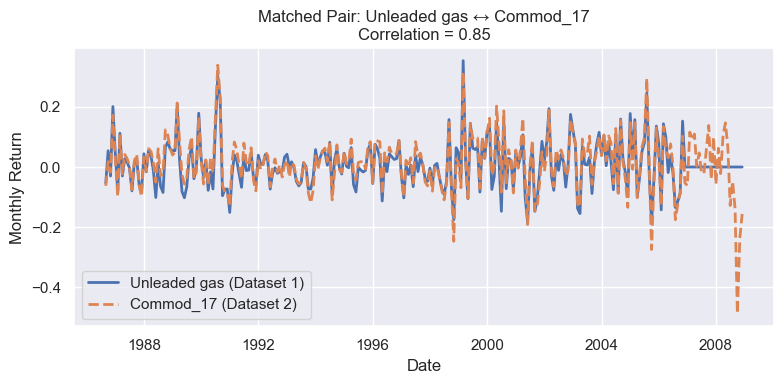

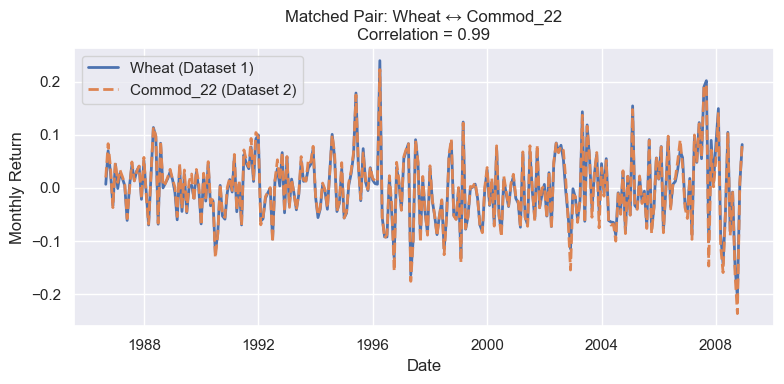

In [94]:
df1 = carry_sub
df2 = he_kelly_sub
for r, c in zip(row_ind, col_ind):
    commodity_1 = corr_matrix.index[r]
    commodity_2 = corr_matrix.columns[c]

    plt.figure(figsize=(8, 4))

    plt.plot(
        df1.index, df1[commodity_1], label=f"{commodity_1} (Dataset 1)", linewidth=2
    )
    plt.plot(
        df2.index,
        df2[commodity_2],
        label=f"{commodity_2} (Dataset 2)",
        linewidth=2,
        linestyle="--",
    )

    plt.title(
        f"Matched Pair: {commodity_1} ↔ {commodity_2}\nCorrelation = {corr_matrix.iloc[r, c]:.2f}"
    )
    plt.xlabel("Date")
    plt.ylabel("Monthly Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.show()